In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        #convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        
        #adjusting the input size of the first fully connected layer
        self.fc1 = nn.Linear(in_features=480, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        #convolution 1
        x = F.tanh(self.conv1(x))
        #average pooling
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        
        #convolution 2
        x = F.tanh(self.conv2(x))
        #average pooling
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        
        #convolution 3
        x = F.tanh(self.conv3(x))
        
        #dlatten the tensor
        x = x.view(x.size(0), -1)
        
        #dully connected layers
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        
        #softmax activation in the output
        return F.softmax(x, dim=1)


lenet5 = LeNet5()
lenet5

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=480, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

#Resizing to 32x32 so that it works for lenet, convertnig to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#cownloadind the MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform)

#creating dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
len(train_dataset), len(test_dataset)

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 5284054.37it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 14535120.45it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 5625635.11it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



(60000, 10000)

Epoch [1/10], Loss: 1.5987, Accuracy: 88.93%
Epoch [2/10], Loss: 1.5004, Accuracy: 96.61%
Epoch [3/10], Loss: 1.4872, Accuracy: 97.75%
Epoch [4/10], Loss: 1.4813, Accuracy: 98.21%
Epoch [5/10], Loss: 1.4775, Accuracy: 98.55%
Epoch [6/10], Loss: 1.4752, Accuracy: 98.78%
Epoch [7/10], Loss: 1.4737, Accuracy: 98.89%
Epoch [8/10], Loss: 1.4721, Accuracy: 99.05%
Epoch [9/10], Loss: 1.4709, Accuracy: 99.11%
Epoch [10/10], Loss: 1.4702, Accuracy: 99.19%
Test Accuracy: 98.43%


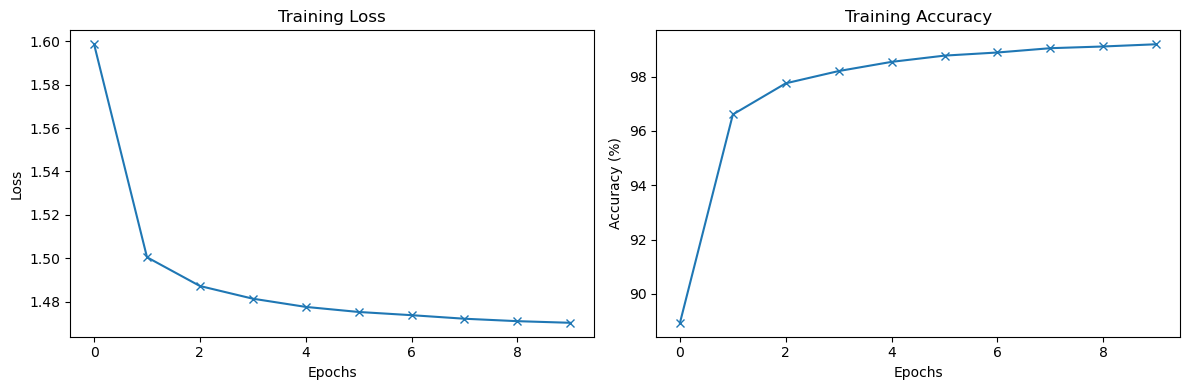

In [6]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 10

#loss function and optimizer used as described in the lab-2 material
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=learning_rate)

# Lists to store loss and accuracy values for visualization
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    lenet5.train()  # Setting model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for images, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = lenet5(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # computing training loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    #computing the average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_predictions / total_predictions

    #Storing loss
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Testing
lenet5.eval()  # Setting model to eval mode
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = lenet5(images)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

test_accuracy = 100 * correct_predictions / total_predictions
print(f"Test Accuracy: {test_accuracy:.2f}%")

#accuracy graph
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, '-x')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, '-x')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()